In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import regex
import os, sys
import matplotlib.pyplot as plt

# USER INPUTS

In [2]:



"""Experiment name to prepend output files"""
EXPERIMENT = "ratio_graphing-2"

"""Directory path to input data 
    (filtered; output from '1-read_fastq_id_features)
"""
FILTERED_FILEPATH = "../output/filtered-ratios.csv"
# FILTERED_FILEPATH = "../output/filtered-18014.csv"
# FILTERED_FILEPATH = '../../../2016-09-19-validation_graphs_redoes/data/filtered-ratios.csv'
"""Directory path to save output"""
OUTPUT_DIRECTORY = "../output"

"""Minimum number of reads as a baseline. Used to simplify data processing."""
MIN_READS = 100


# PRESETS AND SCRIPT

In [3]:
"""
# NEED TO FIGURE HOW TO RELOAD DEPENDENT FUNCTIONS
UPON VALUE CHANGES
Column names correspoinding to eponymous variables"""

SAMPLE = 'idx'
QTAG = 'qtag'
BARCODE = 'barcode'
READS = 'readsPF'
MCOUNTS = 'mcountsPF'
PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
GROUPBY = ['idx']# for older versions/ formats

In [4]:
def check_inputs():
    
    # modules
    assert pd
    assert np
    assert regex
    assert os
    assert sys
    
    # user experiment inputs 
    assert EXPERIMENT
    assert FILTERED_FILEPATH
    assert OUTPUT_DIRECTORY
    assert MIN_READS
    
    # user columns
    assert SAMPLE
    assert QTAG
    assert BARCODE
    assert READS
    assert MCOUNTS
    assert PERCENT_MCOUNTS
    assert GROUPBY
    

In [5]:
# 2016-11-04 updated to include filter delete bool feature
"""calculate_percent_molecs
    calculates percent of mcounts of barcodes.
    df: pd.DataFrame() 
    mcounts: str, optional, col to calculate percents, default MCOUNTS
    percent_mcounts: str, col to assign values to, default PERCENT_MCOUNTS
    filters: list, np.array, dict, columns and bool values to filter values
    
    Returns: 
        df with updated percent_mcounts values
"""
def calculate_percent_molecs(df, mcounts=MCOUNTS, percent_mcounts=PERCENT_MCOUNTS, filters=[]):
    """Updates percent molec counters for sample"""
    
    df.loc[:,percent_mcounts] = 0.
    if len(filters) > 0:
        var, val = filters[0]
        cond = (df[var]==val)
        i = 1
        while i < len(filters):
            var, val = filters[i]
            cond = cond & (df[var]==val)
            i+=1
    else:
        cond = ()
    total = df.loc[cond, mcounts].values.sum() / 100.
    df.loc[cond,percent_mcounts] = df.apply(lambda x: x[mcounts]/total, axis=1)
    df.sort_values(by=[percent_mcounts,mcounts, BARCODE], 
                   ascending=[0,0,1], inplace=True)
    return df

In [6]:
def load_data(filtered_file, sample=SAMPLE, qtag=QTAG, 
              barcode=BARCODE, mcounts=MCOUNTS, reads=READS):
    """Loads filtered lib-ID-barcode data csv to dict of samples"""
    columns = [sample, qtag, barcode, mcounts, reads]
    # loads excel file (all tabs)
    
    csv = pd.read_csv(filtered_file)
    # filter out null barcodes just in case (if custom user input)
    csv = csv.loc[(csv[qtag]!='None') & (csv[barcode]!='None')]
    csv = csv[columns]
    csv[sample] = csv[sample].apply(lambda x: str(x))
    # get percent molecs per sample, store as output dict entry 
    groups = csv.groupby(sample)
    data = []
    for i, group in csv.groupby(sample):
        data.append((i,calculate_percent_molecs(group)))
    return data


In [7]:
def check_data(d, sample=SAMPLE, mcounts=MCOUNTS, reads=READS):
    """Check data for proper format, input values, and 
    converts into list-like object if necessary

    d(list, np.array ,dict, or pd.DataFrame): input data
    
    Returns: data set as a list-like object, wherein
        each item is a pair containing sample name (str) and 
        sample data (pd.DataFrame), in that order.
    """
    data_arr = []
    # wrangle data to list of list-like pairs, as "[idx, df]"
    if type(d) in [np.array, list] :
        data_arr = d
    elif type(d) == dict:
        data_arr = d.items()
    elif type(d) == pd.DataFrame :
        data_arr = [(s,df) for s,df in d.groupby(sample)]
    else:
        print "Input data is not in correct format. Please provide \
        list-like, dict, or pd.DataFrame object."
    
    # check input has correct values
    try:
        for a in data_arr:
            assert len(a) == 2, "incorrect item length"
            s, df = a
            assert type(s) == str, 'sample name is not string type'
            assert type(df) == pd.DataFrame, "incorrect value type: must be pd.DataFrame"
            assert sample in df.columns, "%s not in dataframe"%sample
            assert mcounts in df.columns, "%s not in dataframe"%mcounts
            assert reads in df.columns, "%s not in dataframe"%reads
    # if no 
    except IndexError as e:
        print "Item number of values is not 2.\n"
        print "IndexError. ",e.message
        print a
    except ValueError as e:
        print "Sample name could not be converted to float: %s\n"% type(item[i])
        print "ValueError. ",e.message
        print a
    except AssertionError as e:
        print "Assertion failed:"
        print e.message
        print a
    
    return data_arr

In [38]:
"""OLD THRESHOLD"""

def threshold(group, reps_remaining, thresh_mcounts,threshold_log,
             mcounts=MCOUNTS):
    """Thresholds barcodes of a given sample

        group(pd.DataFrame): df containing library-ID-barcodes, 
            mcountsPF and percent_mcountsPF
        reps_remaining(int): reps remaining from max number 
            input from user 
        thresh_val(float or int): initial threshold value (percent_mcountPF)
            provided from previous recursion or user input
        thresh_i(int): initial position of threshold value in 
            percent_mcountsPF list, ranging 0,len(group)

        Returns: 
            None, if thresholding fails;
            passed(pd.DataFrame), if thresholding successful; or
            self, otherwise, with updated threshold values and 
                group df.
    """
#     print "\nSTART", len(group)
    # max out reps
    if reps_remaining <= 0:
        print 'Maxed out reps. Skipping sample.'
    # no barcodes passed threshold 
    elif len(group) == 0:
        print "No barcodes passed threshold. Skipping sample."
    else:
        # calculate new threshold 
        group.sort_values(by=mcounts, ascending=False, inplace=True)
        mcount_vals = group.loc[(group['passed']==True)|(group['is_padding']==True)][mcounts].values
#         mcount_vals = thresh_group[mcounts].values
#         mcount_vals = mcount_vals + [1] if thresh_mcounts < 0 or len(thresh_group) <= 3 else mcount_vals
#         print "G", group
#         print "THRG", thresh_group
#         print"MCV",  mcount_vals
#         print "else", reps_remaining, len(group), len(mcount_vals)
        new_thresh_mcounts = calculate_threshold(mcount_vals)
#         print "after", reps_remaining, len(group), thresh_mcounts, new_thresh_mcounts
        
        threshold_log.append(len(group.loc[(group[mcounts]>=new_thresh_mcounts)&(group['passed']==True)]))
        print '\n',reps_remaining, len(group)
        print 'old', thresh_mcounts
        print group.loc[(group[mcounts]>=thresh_mcounts)&(group[mcounts]>1)][['qtag','barcode','mcountsPF','passed','is_padding']]
        print 'new', new_thresh_mcounts
        print group.loc[group[mcounts]>=new_thresh_mcounts][['qtag','barcode','mcountsPF','passed','is_padding']]
#         print len(thresh_group.loc[thresh_group[mcounts]>new_thresh_mcounts])
        
#         print len(group), len(thresh_group)
        # if reached steady state
        if new_thresh_mcounts == thresh_mcounts:
#             re_thresholded_v = calculate_threshold(group.loc[group['passed']==True][mcounts].values)
#             print thresh_mcounts, re_thresholded_v
#             passed = eliminate_oneoffs(group, re_thresholded_v, pad=False)
#             passed = eliminate_oneoffs(group, new_thresh_mcounts, pad=False)
#             print len(group.loc[group['passed']==True]), len(passed.loc[passed['passed']==True])
            group['passed'] = group.apply(lambda x:
                            True if x['passed']==True and
                            x['is_padding']==False and
                            x[mcounts]>=new_thresh_mcounts else False, axis=1)
            passed_val = group.loc[group['passed']==True,mcounts].min()
            threshold_log.append(len(group.loc[group[mcounts]>=passed_val]))

            print 'final'
            print group.loc[group['passed']==True][['qtag','barcode','mcountsPF','passed','is_padding']]
#             group.loc[(group['passed']==True)
#                               &(group['is_padding']==False)
#                               &(group[mcounts]>=thresh_mcounts)]
            
            group = calculate_percent_molecs(group,filters=[['passed',True],['is_padding',False]])
#             passed = calculate_percent_molecs(group, 
#                         filters=[['passed',True],['is_padding',False]])
            group.reset_index(inplace=True,drop=True)
            print "FINAL", len(group.loc[group['passed']==True])
            sys.stdout.write('Thresholded.\n')
            return group, threshold_log
        # recursively clean and re-threshold
        else:
#             print reps_remaining
#             print len(group), thresh_mcounts, new_thresh_mcounts
            # clean up group by eliminating one-offs
            cleaned = eliminate_oneoffs(group,new_thresh_mcounts)
            cleaned.reset_index(inplace=True,drop=True)
#             print reps_remaining, len(cleaned.loc[cleaned['passed']==True])
            # recurse with cleaned df and new threshold values
            return threshold(cleaned, reps_remaining-1, new_thresh_mcounts, threshold_log,
                             mcounts=mcounts)
        
    # if thresholding failed, return None
    sys.stdout.write('Skipped.\n')
    return pd.DataFrame()

In [9]:
# STEP 2: CALCULATE THRESHOLD VALUE via. CONCAVITY


def calculate_threshold(y, by='passed', mcounts=MCOUNTS):
    """Calculates threshold of series with modified concavity approach

        y(np.array or list): list or list-like object of 
            values as floats or ints

        Returns index of inflection point in array, 
            i.e. threshold position.
    """
    def rolling_window(arr):
        """Constructs list of overlapping subarray ranges of size 2"""
        shape = arr.shape[:-1] + (arr.shape[-1]-1, 2)
        strides = arr.strides + (arr.strides[-1],)
        windows = np.lib.stride_tricks.as_strided(arr, 
                              shape=shape, strides=strides)
        return windows
    def first_d_gen(windows):
        """Generates first derivative of windows as relative difference"""
        for w in windows:
            # amended 2016-10-12: normalize by y midpoint instead of second point to 
            # better represent the count magnitude of segment
            yield float(w[1]-w[0])/(w[0]+w[1])*2
    def second_d_gen(windows):
        """Generates second derivative of windows"""
        for w in windows:
            yield w[1]-w[0]       
            
    if type(y) in [np.ndarray, list]:
        x_temp = np.array([])
        y_temp = np.array(y)
    else:
        y = pd.DataFrame(y)
        sortby, cond = [mcounts], (y[mcounts]>0)
        if by in y.columns:
            sortby, cond = ['passed']+sortby, cond&(y['passed']==True) 
        passed = y.loc[cond].sort_values(by=sortby,ascending=False)[mcounts]
        x_temp = passed.index.values
        y_temp = passed.values
    
    
    y_temp = np.sort(np.array(y_temp))[::-1]
    # left and right padding to cover all array vals in derivations
    suffix = [] if len(y_temp) > 2 else [1]
#     suffix=[]
#     suffix = [] if len(y_temp) > 1 else [y_temp[0]]
#     suffix = [y_temp[len(y_temp)-1]/(y_temp[0]+y_temp[1])*2]
#     if len(y_temp) < 2:
#         suffix = [y_temp[len(y_temp)-1]/2]
#     else:
#         suffix =  [y_temp[len(y_temp)-1] -
#                    (y_temp[len(y_temp)-2]-y_temp[len(y_temp)-1])]
    
    yarray = np.concatenate([ [y_temp[0]], y_temp, suffix])
    # calculates first derivative
    first_windows = rolling_window(yarray)
    first_derivs = np.fromiter(first_d_gen(first_windows), np.float
                               , count=len(first_windows))
    # calculates second derivative
    second_windows = rolling_window(first_derivs)
    second_derivs = np.fromiter(second_d_gen(second_windows), np.float
                                , count=len(second_windows))
    # gets index or position value of inflection point (curves down ), adjust by adding 1
    # for second deriv
    thresh_i = min(np.argmin(second_derivs)+1, len(y_temp)-1)
    thresh_v = y_temp[thresh_i]
    
#     print "min", np.min(second_derivs), np.argmin(second_derivs)
#     print 'max', np.max(second_derivs), np.argmax(second_derivs)
    return thresh_v

In [40]:
def eliminate_oneoffs(g, thresh_val, pad=True,
                      qtag=QTAG, barcode=BARCODE, passed='passed',
                      barcode_error = 'barcode_error',
                      qtag_error = 'qtag_error',
                      mcounts=MCOUNTS):
    """Eliminate barcodes that are one position off from a more-abundant barcode
        group(pd.DataFrame): df containing qtag, barcode, and percent_mcounts columns
        thresh_val(float): threshold value to select high abundant barcodes
            to iterate through as 'major' ones
        pad(bool): if True, adds a right pad so last non-eliminated value 
            can be analyzed in by the threshold() function. Default True.
        qtag, barcode, percent_mcounts, mcounts (str): column names for the corresponding
            argument. Defaults are global vars QTAG, BARCODE, PERCENT_MCOUNTS, MCOUNTS.

        Returns: table of barcodes that passed elimination
        
        For regex package info, see https://pypi.python.org/pypi/regex/
    """
    g.sort_values(by=mcounts, ascending=False, inplace=True)
    
    g.loc[:,'is_padding'] = False
    failed = []
#     print "elim", len(g), thresh_val, len(g.loc[g['passed']==True]), len( g.loc[(g['passed']==True)&(g[mcounts])>=thresh_val])
#     majors = filter_g.loc[(filter_g[mcounts])>thresh_val]
    i = 0
    # add capability to check other parameters, i.e. qtag
#     for maj_i, maj_r in g.loc[(g['passed']==True)&(g[mcounts])>=thresh_val].iterrows():
    for maj_i, maj_r in g.loc[g['passed']==True].iterrows():
        # if it has not yet been tested
        if g.loc[maj_i,'passed'] == True:
#             print 'passed maj', maj_r[mcounts]
#             minors = filter_g.loc[filter_g[mcounts]<maj_r[mcounts]]

            minors = g.loc[(g['passed']==True)&(g[mcounts]<maj_r[mcounts])]

            # for each 'minor' barcode aka. with fewer molecs, test if one-off from major
            for min_i, min_r in minors.iterrows():
                query = regex.search("(%s){s<=1}"% maj_r[barcode], min_r[barcode])
                if query:
                    g.loc[min_i,'passed'] = False
                    g.loc[min_i,'barcode_error'] += 1 if sum(query.fuzzy_counts)>0 else 0
                    g.loc[min_i,'qtag_error'] += 1 if min_r[qtag]!=maj_r[qtag] else 0
#                     if min_r[mcounts] < thresh_val:
                    failed.append([min_i, min_r[mcounts]])
                                          
            i+=1
                    
#     # if requested, adds a right pad  
#     # line added 2016-10-12: combine two conditions: ensure that 
#     # no null rows get added if all barcodes are accepted
#     g.loc[:,'passed'] = g.apply(lambda x: False if g.index in failed else x['passed'], axis=1)
#     print len(g), len(g.loc[g['passed']==False]), len(failed)
#     print "THR VAL",thresh_val
#     print g
#     print g['passed']==False
    if len(failed) > 0:
        failed.sort(key=lambda x: x[1])
        failed = failed[::-1]
    g.loc[g[mcounts] < thresh_val, 'passed'] = False
#     if pad==True and len(failed) > 0:
    if pad==True and len(g) != len(g.loc[g['passed']==False]):
        pad_i = [f[0] for f in failed[:1]]
        pad_i = g.loc[(g['passed']==False),mcounts][:1].index.values
#         print "PADI", pad_i
        for pi in pad_i:
            g.loc[pi,'is_padding'] = True
#         print "PADI ADJ"
#         print g
    return g
            

In [20]:
def run_threshold(d, sample=SAMPLE, qtag=QTAG, barcode=BARCODE, 
                  mcounts=MCOUNTS, reads=READS, percent_mcounts=PERCENT_MCOUNTS,
                  min_reads=MIN_READS, min_mcount=50):
    """Run threshold algorithm for each sample in dataset

        d(np.array, list, dict, or pd.DataFrame): dataset for all samples
        sample, qtag, barcode, mcounts, reads, percent_mcounts(str): columns in df for 
            corresponding vals. Defaults are global vars SAMPLE, QTAG, BARCODE, MCOUNTS, 
            READS, PERCENT_MCOUNTS.
        min_reads(int): minimum number of reads for a library-ID-barcode as an 
            absolute baseline (that which any barcode below is highly likely to be 
            false.) Default is global var MIN_READS.
        min_mcount(int): minimum number of molecs for library-ID-barcode as an
            absolute baseline. Default is 50.

        Note: min_reads and min_mcount are applied to increase performance.

        Returns: 
            pd.DataFrame, if successful, of 'true' (passed) library-ID-barcodes 
                for all samples
            None, if no samples had passing library-ID-barcodes.
    """
    passed = []
    all_threshold_logs = {}
    counter = 1
    # checks and formats data (d) to list-like obj of pairs
    data_arr = check_data(d, sample=sample, mcounts=mcounts, reads=reads)
    # run for each (sample, df) in dataset 
    for s, group in data_arr:
        sys.stdout.write("\n-------------\nSample %d of %d (%s): "%(counter,len(data_arr),s))
        # select valid data meeting absolute baseline 
        g = group.loc[(group[qtag] != 'None') & (group[barcode] != 'None') 
                          & (group[mcounts] > min_mcount)]
#                           & (group[reads] > min_reads)]
        if len(g)>0:
            g.loc[:,'passed'] = True
            g.loc[:,'qtag_error'] = False
            g.loc[:,'barcode_error'] = False
            g.loc[:,'is_padding'] = False
            result, tlogs = threshold(g, 20, -1, [])
            passed.append(result)
            all_threshold_logs[s] = tlogs
        sys.stdout.flush()
        counter += 1


    # if we do have data (i.e. some barcodes that passed in the samples)
    if len(passed) > 0:
        # concat all df together
        passeddf = pd.concat(passed)
        passeddf.sort_values(by=[sample,percent_mcounts]
                             ,ascending=[True, False]
                             ,inplace=True)
        passeddf.reset_index(inplace=True,drop=True)
        return passeddf, all_threshold_logs
    else:
        print "No samples were successfully thresholded."
    return 

### SCRIPT TO SAVE DATA TO CSVs

In [12]:
def save_data(filtered,passed, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT):
    
    # Save passed dataframe
    passed.to_csv('%s/threshold-%s-passed.csv'%(output_directory,experiment), index=False)
    # count and save results
    counts = count_sample_barcodes(passed)
    counts.to_csv('%s/threshold-%s-counts.csv'%(output_directory,experiment), index=False)
    # merge passed and filtered data and save
    fc_temp = pd.concat([d[1] for d in filtered])
    filtered_concat = apply_passed_data(fc_temp, passed)
    filtered_concat.to_csv('%s/threshold-%s-merged.csv'%(output_directory,experiment), index=False)

In [13]:
def count_sample_barcodes(df, groupby=SAMPLE, barcode=BARCODE, sample=SAMPLE, qtag=QTAG
                      , percent_mcounts=PERCENT_MCOUNTS):
    """Counts passed barcodes per sample and saves as csv
    
        df(pd.DataFrame): input dataframe containing passed 
            barcodes of all samples
        groupby(str or list-like): columns to group samples by
    """
    agg = df.groupby(groupby).agg(len)
    counts = agg[agg.columns[0]]
    counts.name = 'count'
    counts = pd.DataFrame(counts)
    counts.reset_index(inplace=True)
    return counts



In [14]:
def apply_passed_data(filtered, passeddf, sample=SAMPLE, qtag=QTAG
                      , barcode=BARCODE, percent_mcounts=PERCENT_MCOUNTS):
    """Cross reference passed barcodes with raw filtered data
        filtered(pd.DataFrame): raw filtered data as dataframe for all samples
        passed(pd.DataFrame): data passed threshold (output of run_threshold)
        sample,qtag,barcode,percent_mcounts(str): names corresponding to df columns.
            Defaults are SAMPLE,QTAG,BARCODE,PERCENT_MCOUNTS.

        Returns:
            filtered(pd.DataFrame) updated with 'passed_threshold' and 
            percent_mcounts columns
    """
    def cross_ref_passed(row):
        key = (row[sample],row[qtag],row[barcode])
        if key in passed_indexed.index:
            row.loc[:,percent_mcounts+'_thresholded'] = passed_indexed.loc[key,percent_mcounts]
            row.loc[:,'passed_threshold'] = True
        return row

    passed_indexed = passeddf.set_index([sample,qtag,barcode])
    filtered.rename(columns={percent_mcounts:percent_mcounts+'_filtered'})
    filtered.loc[:,'passed_threshold'] = False
    filtered.loc[:,percent_mcounts+'_thresholded'] = 0
    filtered = filtered.apply(cross_ref_passed, axis=1)
    return filtered



# EXECUTE SCRIPT BELOW

In [39]:
if __name__=='__main__':
    # Check all inputs exist and are valid
    check_inputs()
    # Runs data loading in script
    filtered = load_data(FILTERED_FILEPATH)
    # Run thresholding of all samples in dataset
    passeddf, all_threshold_logs = run_threshold(filtered)
#     save_data(filtered, passeddf, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT)

C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-------------
Sample 1 of 27 (1): 

C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20 5
old -1
    qtag  barcode  mcountsPF passed is_padding
140  q19  GGGCGGC      79618   True      False
141  q19  GGGCGAC        266   True      False
142  q19  GGGCAGC        152   True      False
143  q19  GGGTGGC         55   True      False
144  q19  GGACGGC         52   True      False
new 266
    qtag  barcode  mcountsPF passed is_padding
140  q19  GGGCGGC      79618   True      False
141  q19  GGGCGAC        266   True      False

19 5
old 266
  qtag  barcode  mcountsPF passed is_padding
0  q19  GGGCGGC      79618   True      False
1  q19  GGGCGAC        266  False       True
new 266
  qtag  barcode  mcountsPF passed is_padding
0  q19  GGGCGGC      79618   True      False
1  q19  GGGCGAC        266  False       True


C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


final
  qtag  barcode  mcountsPF passed is_padding
0  q19  GGGCGGC      79618   True      False
FINAL 1
Thresholded.

-------------
Sample 2 of 27 (10): 
20 14
old -1
    qtag  barcode  mcountsPF passed is_padding
983  q24  CCAGTTG      41816   True      False
984  q24  ATTCGCT      15702   True      False
985  q25  ACAATGA       9662   True      False
986  q24  ACAATGA       2339   True      False
987  q25  CCAGTTG       2249   True      False
988  q24  CCCGTTG       1520   True      False
989  q25  ATTCGCT        829   True      False
990  q24  CTTCGCT        538   True      False
991  q25  CCAATGA        333   True      False
992  q25  ACCATGA        281   True      False
993  q25  CCCGTTG         85   True      False
994  q24  CCAATGA         82   True      False
995  q24  ACCATGA         63   True      False
996  q24  CCAGTTT         63   True      False
new 15702
    qtag  barcode  mcountsPF passed is_padding
983  q24  CCAGTTG      41816   True      False
984  q24  ATTCGCT      1

In [23]:
fconcat = pd.concat([d[1] for d in filtered if d[0][:2]!="VL" ])
merged = fconcat.merge(passeddf, 
              on=['idx','qtag','barcode','mcountsPF','readsPF'], 
                       how='outer')
merged.drop(['percent_mcountsPF_x','is_padding'],axis=1, inplace=True)
merged.rename(columns={'percent_mcountsPF_y':"percent_mcountsPF"}, inplace=True)
merged = merged.fillna(value={'passed':False,'qtag_error':False,'barcode_error':False,
                    'percent_mcountsPF':0.})

In [19]:
passeddf.loc[passeddf['passed']==True]

idx qtag  barcode  mcountsPF  readsPF  percent_mcountsPF passed  \
0      1  q19  GGGCGGC      79618   102145         100.000000   True   
30    10  q24  CCAGTTG      41816    47259          72.700720   True   
31    10  q24  ATTCGCT      15702    16376          27.299280   True   
119   11  q26  CGTAAAC      81232   104913          91.154127   True   
120   11  q27  GCGGTAG       7883     8044           8.845873   True   
171   12  q19  CTGGCGT      78535   100514          95.486765   True   
172   12  q24  GCTTTAG       3712     3739           4.513235   True   
214   13  q25  CCCGTCT      69129    85469          99.711520   True   
215   13  q26  CATATAT        200      201           0.288480   True   
263   14  q19  GGGCGGC      21111    22459          40.854201   True   
264   14  q27  CGCATAG      16209    16977          31.367806   True   
265   14  q24  CAGAAGT      14354    14904          27.777993   True   
353   15  q25  GGAGCCA      17705    18607          47.230966   True   
354   15  q27  GAGGAGT      10116    10409          26.986075   True   
355   15  q26  CGCTTTG       9665     9944          25.782959   True   
444   16  q19  CCGCCTG      35493    39366          83.634950   True   
445   16  q25  ACAATGA       6945     7090          16.365050   True   
538   17  q19  CTGGCGT       5933     6028          35.620797   True   
539   17  q24  GCTTTAG       5218     5305          31.328050   True   
540   17  q26  CGTAAAC       2852     2879          17.122959   True   
541   17  q27  GCGGTAG       2653     2678          15.928194   True   
607   18  q19  GGGCGGC      14184    14750          33.686410   True   
608   18  q24  CAGAAGT      11074    11405          26.300290   True   
609   18  q27  CGCATAG      10387    10676          24.668693   True   
610   18  q26  CATATAT       6461     6583          15.344606   True   
754   19  q19  CCGCCTG       7671     7840          26.459023   True   
755   19  q26  CGCTTTG       6449     6564          22.244067   True   
756   19  q24  CCAGTTG       5745     5832          19.815811   True   
757   19  q27  GAGGAGT       5450     5544          18.798289   True   
758   19  q25  ACAATGA       3677     3721          12.682809   True   
...   ..  ...      ...        ...      ...                ...    ...   
1145  22  q26  CGCTTTG      40450    45571          90.251902   True   
1146  22  q25  ACAATGA       4369     4421           9.748098   True   
1296  23  q27  GCGGTAG      37849    42369          90.932898   True   
1297  23  q19  CTGGCGT       3774     3831           9.067102   True   
1407  24  q19  GGGCGGC      12299    12736          27.973253   True   
1408  24  q27  CGCATAG      11083    11455          25.207542   True   
1409  24  q26  CATATAT       7881     8031          17.924807   True   
1410  24  q24  CAGAAGT       7192     7347          16.357723   True   
1411  24  q25  GGAGCCA       5512     5603          12.536675   True   
1549  25  q26  CGCTTTG      19390    20515          37.998001   True   
1550  25  q27  GAGGAGT      14273    14838          27.970370   True   
1551  25  q19  CCGCCTG       9789    10048          19.183210   True   
1552  25  q24  CCAGTTG       4173     4222           8.177703   True   
1553  25  q25  ACAATGA       3404     3448           6.670717   True   
1725  26  q26  CGTAAAC      19019    20018          66.217534   True   
1726  26  q19  CTGGCGT       9703     9960          33.782466   True   
1827  27  q25  ACAATGA          1        1          50.000000   True   
1828  27  q26  CGTAAAC          1        1          50.000000   True   
1829   3  q24  GCTTTAG         40       40          93.023256   True   
1830   3  q25  GGAGCCA          3        3           6.976744   True   
1836   4  q24  GCTTTAG      89143   118591         100.000000   True   
1867   5  q27  CGCATAG      71214    88842         100.000000   True   
1896   6  q25  GGAGCCA          5        5          71.428571   True   
1897   6  q27  CGCATAG          2        2   

In [138]:
merged.loc[(merged['passed']==True)|(merged.mcountsPF > 300)]

idx qtag  barcode  mcountsPF  readsPF  percent_mcountsPF passed  \
0          1  q25  TTGCTTC      21979    23011         100.000000   True   
37    180-10  q19  TTGTGGC       3516     4600          80.018207   True   
38    180-10  q24  CGGTGTG        878     1104          19.981793   True   
118   180-12  q19  TTGTGGC       1453     1616          67.268519   True   
119   180-12  q24  CGGTGTG        707      746          32.731481   True   
165        2  q24  GGTTGAT      61172    68931         100.000000   True   
223       20  q19  GATCCAT     189720   465296         100.000000   True   
363       21  q23  GTTTCTG      13552    13456         100.000000   True   
390       22  q23  GTTTCTG     166365   339984         100.000000   True   
391       22  q23  GTTTCTA        364      316           0.000000  False   
392       22  q23  GTTTCCG        360      307           0.000000  False   
481       23  q24  GCGTCTC      15262    15289         100.000000   True   
515       24  q24  GGGATAT      21939    22133         100.000000   True   
559       25  q19  TGTATGG      42568    48312         100.000000   True   
610       26  q19  TGTATGG      21539    22583         100.000000   True   
641       27  q19  ATCCTTT      24880    26404         100.000000   True   
690       28  q23  GTTTCTG      28217    29812          45.766698   True   
691       28  q19  TGTATGG      21353    21946          34.633600   True   
692       28  q24  GGGATAT      12084    11757          19.599702   True   
693       28  q19  GTTTCTG       1458     1372           0.000000  False   
694       28  q23  TGTATGG       1315     1225           0.000000  False   
695       28  q24  GTTTCTG       1018      917           0.000000  False   
696       28  q24  TGTATGG        791      716           0.000000  False   
697       28  q23  GGGATAT        682      604           0.000000  False   
698       28  q19  GGGATAT        601      533           0.000000  False   
815       29  q19  GGTGGGC      68425    78713         100.000000   True   
816       29  q19  GGTGTGC        584       32           0.000000  False   
817       29  q19  GGTTGGC        456       49           0.000000  False   
895        3  q24  GAGTGTG      14220    13854          59.013944   True   
896        3  q23  AGTTATT       9876     9396          40.986056   True   
897        3  q23  GAGTGTG        614      560           0.000000  False   
898        3  q24  AGTTATT        607      532           0.000000  False   
950        4  q23  GTTTCTG      28058    30154         100.000000   True   
980        5  q19  GAACTTC     103126   149848         100.000000   True   
1046       6  q23  GTTTCTG      23803    24691         100.000000   True   
1078       7  q23  ATTGTGT      28025    28960         100.000000   True   

     qtag_error barcode_error  
0         False         False  
37        False         False  
38        False         False  
118       False         False  
119       False         False  
165       False         False  
223       False         False  
363       False         False  
390       False         False  
391       False          True  
392       False         False  
481       False         False  
515       False         False  
559       False         False  
610       False         False  
641       False         False  
690       False         False  
691       False         False  
692       False         False  
693        True         False  
694       False         False  
695       False         False  
696       False         False  
697       False         False  
698       False         False  
815       False         False  
816       False         False  
817       False         False  
895       False         False  
896       False         False  
897        True         False  
898       False         False  
950       False         False  
980       False         False  
1046      False         False  
1078      False         False

In [137]:
passeddf.to_csv("%s/passed-%s.csv"%(OUTPUT_DIRECTORY,EXPERIMENT))

In [36]:
all_threshold_logs

{'1': [2, 2, 1],
 '10': [2, 2, 2],
 '11': [2, 2, 2],
 '12': [2, 2, 2],
 '13': [2, 2, 2],
 '14': [4, 4, 3],
 '15': [4, 4, 3],
 '16': [2, 2, 2],
 '17': [5, 5, 4],
 '18': [28, 4, 4, 4],
 '19': [5, 5, 5],
 '2': [2, 2, 1],
 '20': [6, 6, 5],
 '21': [6, 6, 5],
 '22': [2, 2, 2],
 '23': [2, 2, 2],
 '24': [6, 6, 5],
 '25': [6, 6, 5],
 '26': [2, 2, 2],
 '4': [2, 2, 1],
 '5': [2, 2, 1],
 '7': [3, 3, 2],
 '8': [3, 3, 2],
 '9': [6, 2, 2, 2]}

In [50]:
passed_counts = passeddf.loc[passeddf['passed']==True].groupby('idx').apply(len)

In [30]:
for idx, group in passeddf.groupby('idx'):
    passed_g = group.loc[group['passed']==True,'mcountsPF']
    thresh_val = passed_g.values[-1]
    over_thresh = len(group.loc[group['mcountsPF']>=thresh_val])
    print idx, thresh_val, len(group.loc[group['passed']==True,'mcountsPF']), over_thresh

1 79618 1 1
10 15702 2 2
11 7883 2 2
12 3712 2 2
13 200 2 2
14 14354 3 3
15 9665 3 3
16 6945 2 2
17 2653 4 4
18 6461 4 4
19 3677 5 5
2 75662 1 1
20 1072 5 5
21 5374 5 5
22 4369 2 2
23 3774 2 2
24 5512 5 5
25 3404 5 5
26 9703 2 2
4 89143 1 1
5 71214 1 1
7 33257 2 2
8 26183 2 2
9 19645 2 2


## GRAPHING

In [28]:
itypes = {
    (True,False,False):'passed', #passed
    (False,True,False):'qtag mismatch', #qtag error
    (False,False,True):'barcode oneoff', #barcode error
    (False,False,False):'other error' #not one-off
}

for itype in itypes:
    keys = ['passed','qtag_error','barcode_error']
    ca = [(merged[k]==v) for k,v in zip(keys,itype)]
    cond = ca[0]&ca[1]&ca[2]
    merged.loc[(cond),'itype'] = itypes[itype]
    
ctypes = {
    'passed':'#11BF08',
    'barcode oneoff': '#DE092B',
    'qtag mismatch':'#EBA709',
    'other error':'#2A52D5'
}
itype_order = [
    'passed',
    'other error',
    'barcode oneoff',
    'qtag mismatch'
]

ERROR! Session/line number was not unique in database. History logging moved to new session 202


C:\Users\vwl698\Anaconda2\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


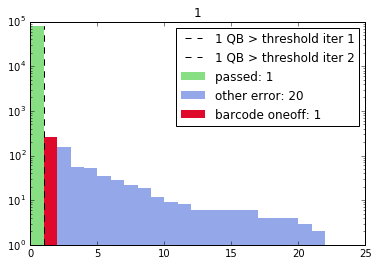

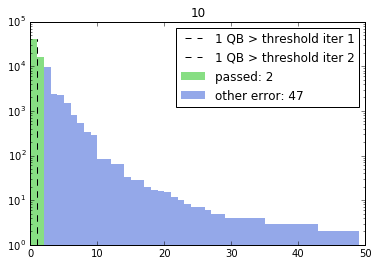

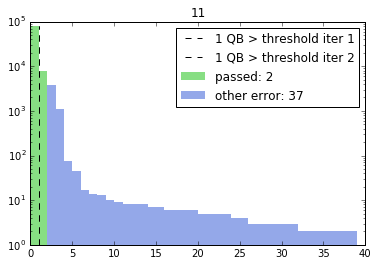

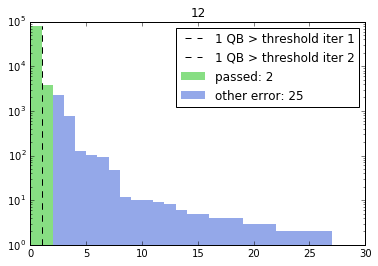

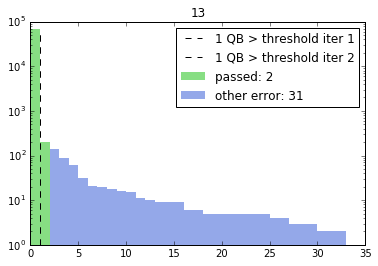

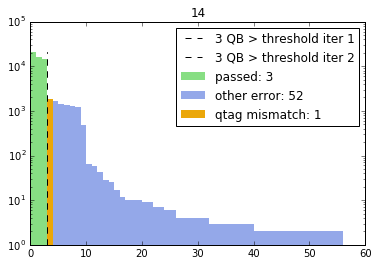

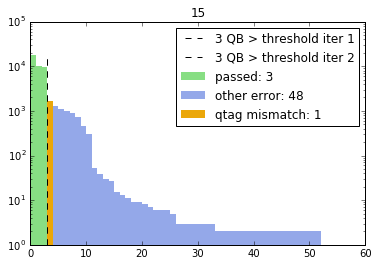

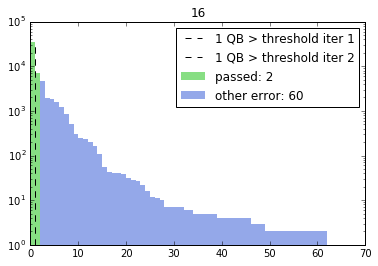

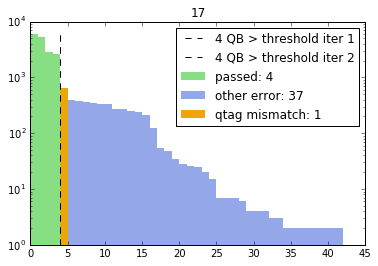

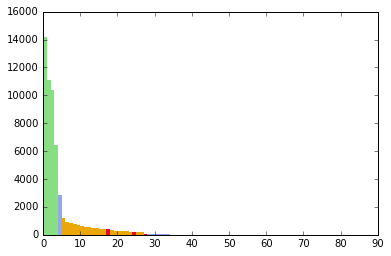

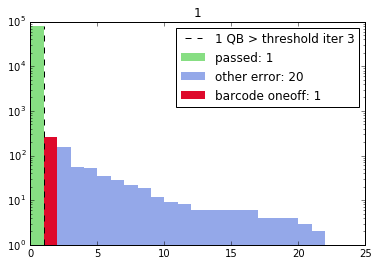

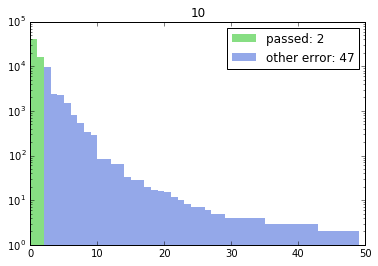

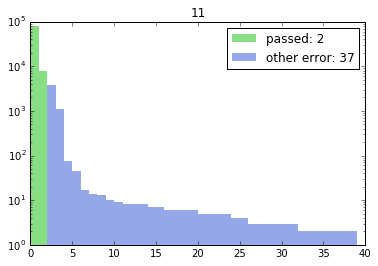

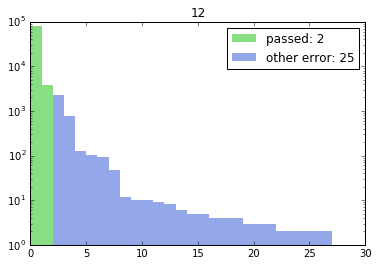

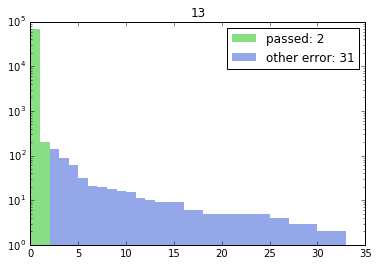

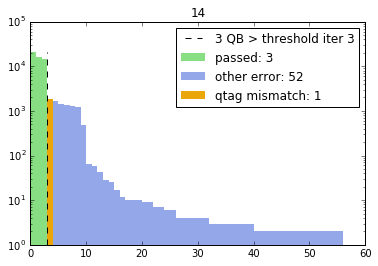

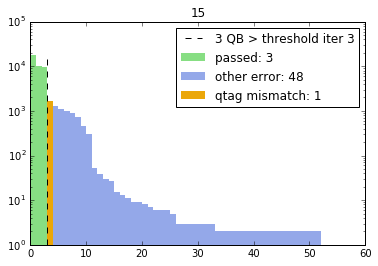

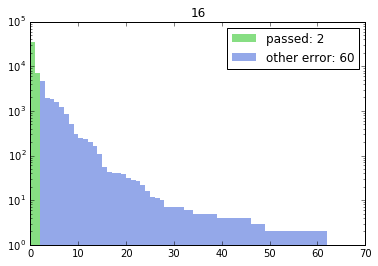

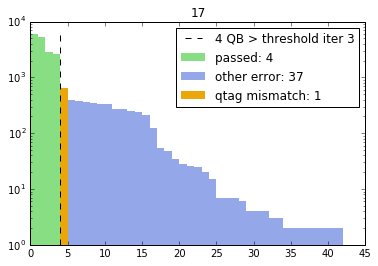

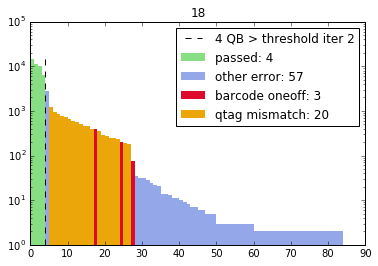

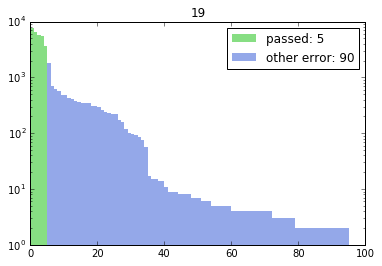

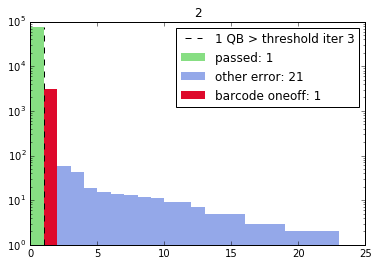

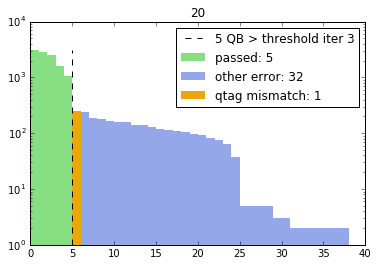

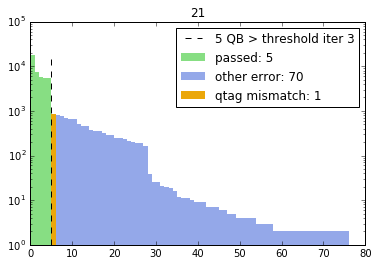

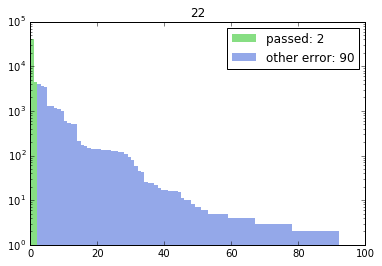

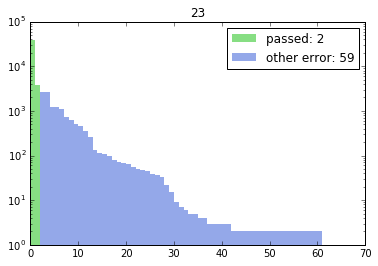

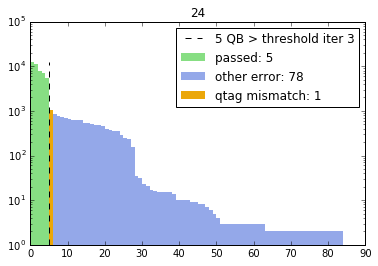

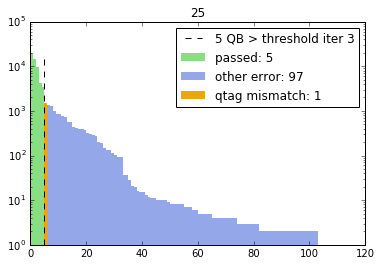

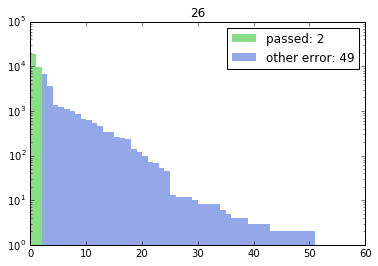

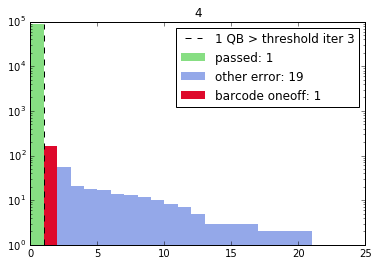

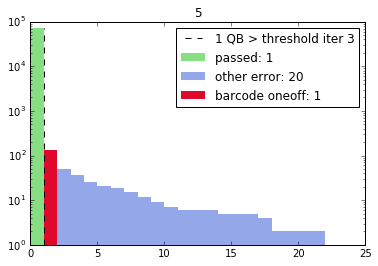

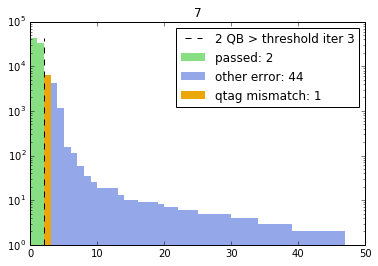

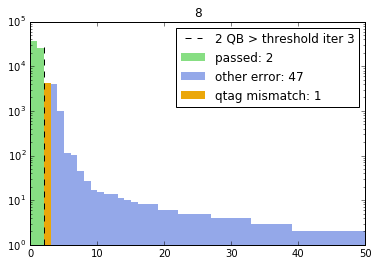

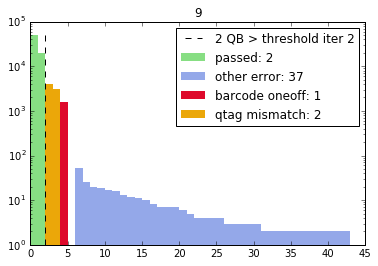

In [35]:
# plots scatter
plottype = 'bar'
mcounts=MCOUNTS
counter = 0
for idx, group in merged.groupby('idx'):
#     if idx[:2]=='NH':
    if idx in all_threshold_logs:
        gslice = group.sort_values(by=mcounts,ascending=False)
        gslice = gslice.loc[gslice[mcounts]>1]
        counts = gslice[mcounts].values
        itypes = gslice.itype.values
        it_present= np.unique(itypes)
        
        f, ax = plt.subplots(1)
        for itype in itype_order:
            if itype in it_present:
                x = np.where(itypes==itype)[0]
                y = counts[x]
                label = "%s: %d"%(itype,len(x))
                color = ctypes[itype]
                alpha = 0.5 if itype in ['passed','other error'] else 1
                edgecolor=color
                lw = 1.5
                s = 250 if itype in ['barcode oneoff','qtag mismatch'] else 8
                marker = "|" if itype in ['barcode oneoff','qtag mismatch'] else "o"
                    
                if plottype == 'scatter':
                    ax.scatter(x+1, y, color=color, edgecolors=edgecolor,
                            alpha=alpha, label=label, 
                            marker=marker, lw=lw, s=s)
                    
                else:
                    ax.bar(x, y, color=color, alpha=alpha, 
                           label=label, lw=0, width=1 )
        
        thresh_values = all_threshold_logs[idx]
        thresh_line_fmts = 1
        for tline in range(1,len(thresh_values)):
            thresh_line = thresh_values[tline]
    #             thresh_line =np.max(np.where(itypes=='passed')[0])+1

            if thresh_line != thresh_values[tline-1]:
#                 alpha = thresh_line_fmts[len(thresh_values)-tline-1]
                alpha = thresh_line_fmts - 0.5*(tline-1)
                ax.plot([thresh_line,thresh_line],[1,max(counts)], 
                        color = 'black', alpha = 1, ls = '--',
                        label='%d QB > threshold iter %d'%(thresh_line, tline+1))
        ax.set_yscale('log')
        ax.set_xlim(0)
        ax.legend()
        ax.set_title(idx)
#         break


    